In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/masksforwordclouds/twitter_mask2.png
/kaggle/input/masksforwordclouds/twitter_mask4.jpg
/kaggle/input/masksforwordclouds/twitter_mask3.jpg
/kaggle/input/masksforwordclouds/book-logo-1.jpg
/kaggle/input/masksforwordclouds/twitter_mask.png
/kaggle/input/masksforwordclouds/wordcloud-man.png
/kaggle/input/masksforwordclouds/twitter_mask3.png
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [4]:
import re
import string
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import Counter

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)


In [5]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding="Latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df=df.dropna(axis=1)
df.columns=["target","message"]
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df["message_len"]=df["message"].apply(lambda x:len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [8]:
max(df["message_len"])

171

In [9]:
df.shape

(5572, 3)

In [10]:
df['target'].value_counts() 

target
ham     4825
spam     747
Name: count, dtype: int64

# **EDA**

In [11]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color="green"
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color="orange"
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

# **Data Preprocessing**

In [13]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
df["message"]=df["message"].apply(clean_text)
df.head()

,target,message,message_len
0,ham,go until jurong point crazy available only in ...,20
1,ham,ok lar joking wif u oni,6
2,spam,free entry in a wkly comp to win fa cup final...,28
3,ham,u dun say so early hor u c already then say,11
4,ham,nah i dont think he goes to usf he lives aroun...,13


**Stopwords**

In [15]:
from nltk.corpus import stopwords
stop_words=stopwords.words("english")
more_stopwords=['u','im','c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text=' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [16]:
df["message"]=df["message"].apply(remove_stopwords)
df.head()

,target,message,message_len
0,ham,go jurong point crazy available bugis n great ...,20
1,ham,ok lar joking wif oni,6
2,spam,free entry wkly comp win fa cup final tkts m...,28
3,ham,dun say early hor already say,11
4,ham,nah dont think goes usf lives around though,13


**Stemming**

In [17]:
import nltk
stemmer=nltk.SnowballStemmer("english")

def Stemming_(text):
    text=' '.join(stemmer.stem(word) for word in text.split(" "))
    return text

In [18]:
df["message"]=df["message"].apply(Stemming_)
df.head()

,target,message,message_len
0,ham,go jurong point crazi avail bugi n great world...,20
1,ham,ok lar joke wif oni,6
2,spam,free entri wkli comp win fa cup final tkts m...,28
3,ham,dun say earli hor alreadi say,11
4,ham,nah dont think goe usf live around though,13


**All preprocessing technique At Once**

In [19]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [20]:
df['message'] = df['message'].apply(preprocess_data)
df.head()

,target,message,message_len
0,ham,go jurong point crazi avail bugi n great world...,20
1,ham,ok lar joke wif oni,6
2,spam,free entri wkli comp win fa cup final tkts m...,28
3,ham,dun say ear hor alreadi say,11
4,ham,nah dont think goe usf live around though,13


In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['target'])

df['target_encoded'] = label_encoder.transform(df['target'])
df.head()

,target,message,message_len,target_encoded
0,ham,go jurong point crazi avail bugi n great world...,20,0
1,ham,ok lar joke wif oni,6,0
2,spam,free entri wkli comp win fa cup final tkts m...,28,1
3,ham,dun say ear hor alreadi say,11,0
4,ham,nah dont think goe usf live around though,13,0


# **Data Visualization**

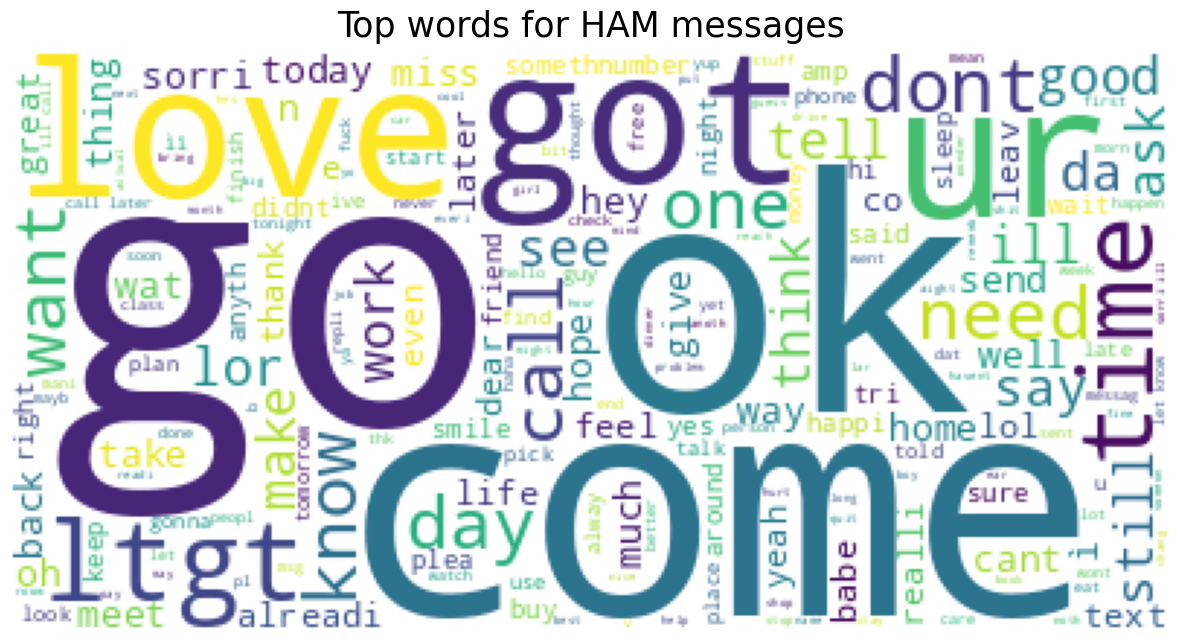

In [22]:
from PIL import Image
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message']))
plt.figure(figsize=(15,9))
plt.title('Top words for HAM messages', 
          fontdict={'size': 25,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
from PIL import Image
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message']))
plt.figure(figsize=(15,9))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 25,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# **Train-Test Split**

In [ ]:
x = df['message']
y = df['target']

print(len(x), len(y))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


**Vectorization as Document Frequency**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
x_train_docfreq = vect.transform(x_train)
x_test_docfreq = vect.transform(x_test)

**Term Frequency Inverse Document Frequency**

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_docfreq)
x_train_tfidf = tfidf_transformer.transform(x_train_docfreq)

x_train_tfidf

<4179x5684 sparse matrix of type '<class 'numpy.float64'>'
	with 32201 stored elements in Compressed Sparse Row format>

**N-GRAM (Bi-gram)**

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
# max_df/min_df : number will be interpreted as a frequency rather than a numerical limit
vect_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

# **Word Embeddings: GloVe**

**Tokenize**

In [ ]:
texts = df['message']
target = df['target']

In [31]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer


# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

2024-03-31 15:48:22.749787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 15:48:22.749883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 15:48:23.026047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


6726

**Pad_sequences**

In [32]:
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences

def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

**Glove(Global Vectors for Word Representation) Unsupervised Algo**

In [33]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [34]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# **Models**

In [35]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

# **Naive Bayes**

In [36]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_docfreq, y_train)

MultinomialNB()

In [37]:
y_pred_class = nb.predict(x_test_docfreq)
y_pred_prob = nb.predict_proba(x_test_docfreq)[:, 1]

In [38]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9784637473079684


In [39]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9742967654258609

# **Naive Bayes using Pipeline**

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(x_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [41]:
y_pred_class = pipe.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9597989949748744


In [42]:
conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

# **XGBoost**

In [43]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=10,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [44]:
x = df['message']
y1=df["target_encoded"]


print(len(x), len(y1))

5572 5572


In [45]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y1, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [46]:
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

In [47]:
print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

Train: 0.9861210815984686
Test: 0.9669777458722182


In [48]:
conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

# **LSTM**

In [49]:
target1=df["target_encoded"]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target1, 
    test_size=0.2
)
print(X_train.shape,y_train.shape)

(4457, 80) (4457,)


In [51]:
y_train

3930    0
1579    0
1230    0
5173    0
3275    0
       ..
5507    0
4703    0
4148    0
3256    0
4966    1
Name: target_encoded, Length: 4457, dtype: int64

In [52]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)

In [68]:
from keras.initializers import RandomNormal
import tensorflow as tf

def glove_lstm(embedding_matrix, length_long_sentence):
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # Pass embedding_matrix as initializer

#         embeddings_initializer=RandomNormal(mean=0.0, stddev=0.05),  # another method for intitalising weights
        input_shape=(length_long_sentence,)  # Use input_shape instead of input_length
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences=True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [69]:
model = glove_lstm(embedding_matrix,length_long_sentence)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 80, 100)        │       672,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 80, 160)        │       115,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 160)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,521 (3.08 MB)

 Trainable params: 808,201 (3.08 MB)

 Non-trainable params: 320 (1.25 KB)

In [70]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model = glove_lstm(embedding_matrix,length_long_sentence)

checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8207 - loss: 0.4304
Epoch 1: val_loss improved from inf to 0.29559, saving model to model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.8211 - loss: 0.4296 - val_accuracy: 0.9623 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9388 - loss: 0.1812
Epoch 2: val_loss improved from 0.29559 to 0.13593, saving model to model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.9388 - loss: 0.1811 - val_accuracy: 0.9587 - val_loss: 0.1359 - learning_rate: 0.0010
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9639 - loss: 0.1226
Epoch 3: val_loss improved from 0.13593 to 0.07600, saving model to model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.9638 - loss: 0.1227 - val_accuracy: 0.9785 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.

In [71]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

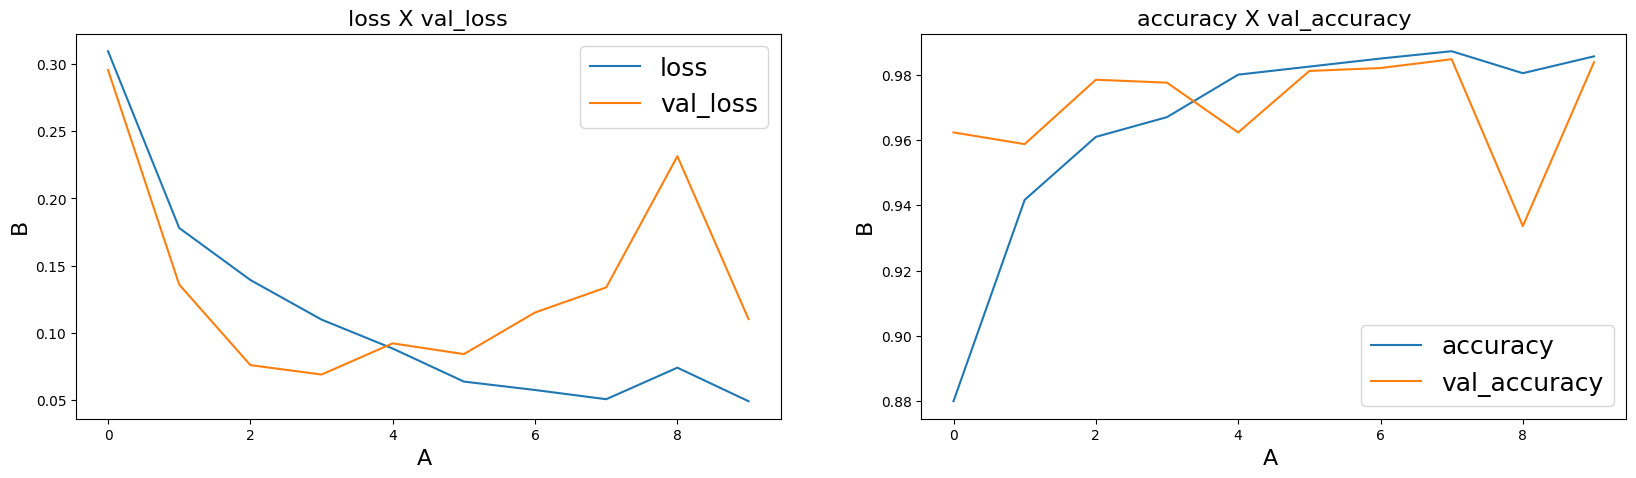

In [72]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [73]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
